<h1>
<center>CFRM 421/521, Spring 2022</center>
</h1>

<h1>
<center>Rohan Tiwari</center>
</h1>

<h1>
<center>Homework 2</center>
</h1>

* **Due: Monday, May 2, 2022, 11:59 PM**


* Total marks: 41


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as one Jupyter notebook on Canvas and one PDF file on Gradescope.** The notebook must be already run, that is, make sure that you have run all your code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Random forest for time series data [13 marks]

In this question you will work with the NYSE dataset. Only 3 time series in this dataset will be use: `DJ_return` ($a_t$), `log_volatility` ($b_t$), and `log_volume` ($c_t$). Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/91091313/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf), which explains the meaning of the variables.

You want to predict the 1-step ahead value of `log_volume` $c_{t+1}$ using the previous values of this variable and the other two variables (`DJ_return` and `log_volatility`) up to 5 lags. So the features are $c_{t},\dots,c_{t-4},b_{t},\dots,b_{t-4},a_{t},\dots,a_{t-4}$.

If the data is stored in a file named `NYSE.csv` in your working directory, then loading the data can be done using the code below.

In [1]:
import os
import pandas as pd
data = pd.read_csv("NYSE.csv")
data.head()

,date,day_of_week,DJ_return,log_volume,log_volatility,train
0,1962-12-03,mon,-0.004461,0.032573,-13.127403,True
1,1962-12-04,tues,0.007813,0.346202,-11.749305,True
2,1962-12-05,wed,0.003845,0.525306,-11.665609,True
3,1962-12-06,thur,-0.003462,0.210182,-11.626772,True
4,1962-12-07,fri,0.000568,0.044187,-11.728130,True


## (a) [3 marks]

Create the feature matrix `X` and the target variable `y`. Print at least the first 2 rows of `X` and `y` (it is acceptable that not every element of the rows are printed).

**[Add your solution here]**

In [2]:
data = data.drop(['date', 'day_of_week', 'train'], axis=1)
data.head(10)

,DJ_return,log_volume,log_volatility
0,-0.004461,0.032573,-13.127403
1,0.007813,0.346202,-11.749305
2,0.003845,0.525306,-11.665609
3,-0.003462,0.210182,-11.626772
4,0.000568,0.044187,-11.728130
5,-0.010824,0.133246,-10.872526
6,0.000124,-0.011528,-10.977797
7,0.003358,0.001607,-11.012360
8,-0.003296,-0.106437,-11.047108
9,0.004469,-0.138269,-11.022063


In [7]:
# import numpy as np
# def ts_split_X(ts, feature_steps=5, target_steps=1):
#     n_obs = len(ts) - feature_steps - target_steps + 1
#     X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
#     #y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
#                   #for idx in range(n_obs)])
#     return X

# # X_train = data.iloc[:4281, :]
# # X1_train = ts_split_X(X_train['DJ_return'])
# # X2_train = ts_split_X(X_train['log_volume'])
# # X3_train = ts_split_X(X_train['log_volatility'])
# # X = np.column_stack((X1_train, X2_train, X3_train))

# # X.shape

# #full datset
# X1_train = ts_split_X(data['DJ_return'])
# X2_train = ts_split_X(data['log_volume'])
# X3_train = ts_split_X(data['log_volatility'])
# X = np.column_stack((X1_train, X2_train, X3_train))
import numpy as np
def ts_split(ts, feature_steps=5, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return X, y

X1 = ts_split(data['log_volume'])[0]
X2 = ts_split(data['log_volatility'])[0]
X3 = ts_split(data['DJ_return'])[0]
y = ts_split(data['log_volume'])[1]

X =  np.hstack((X1, X2, X3))


X.shape

(6046, 15)

In [8]:
X[:2,]

array([[ 3.25730000e-02,  3.46202000e-01,  5.25306000e-01,
         2.10182000e-01,  4.41870000e-02, -1.31274026e+01,
        -1.17493047e+01, -1.16656090e+01, -1.16267724e+01,
        -1.17281302e+01, -4.46100000e-03,  7.81300000e-03,
         3.84500000e-03, -3.46200000e-03,  5.68000000e-04],
       [ 3.46202000e-01,  5.25306000e-01,  2.10182000e-01,
         4.41870000e-02,  1.33246000e-01, -1.17493047e+01,
        -1.16656090e+01, -1.16267724e+01, -1.17281302e+01,
        -1.08725263e+01,  7.81300000e-03,  3.84500000e-03,
        -3.46200000e-03,  5.68000000e-04, -1.08240000e-02]])

In [9]:
# import numpy as np
# def ts_split_y(ts, feature_steps=5, target_steps=1):
#     n_obs = len(ts) - feature_steps - target_steps + 1
#    # X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
#     y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
#                   for idx in range(n_obs)])
#     return y


# # y = ts_split_y(X_train['log_volume'])

# y = ts_split_y(data['log_volume'])

y.shape

(6046, 1)

In [10]:
y[:2, ]

array([[ 0.133246],
       [-0.011528]])

## (b)  [4 marks]

Consider fitting a random forest to predict the 1-step ahead value of `log_volume`. The random forest must include the argument `random_state=42`, and it is useful to also include `n_jobs=-1` (you can use `n_job=-1` throughout this homework wherever it is avaliable). Use 3-fold time series CV, with the test set split 50% into a validation set and 50% into the actual test set, to tune the hyperparameters `n_estimators` taking the values  100, 500, 750, and the cost-complexity pruning parameter $\alpha$ taking the values $10^{-k}$, $k=0,1,\dots,9$. The performance measure is RMSE. Report the best hyperparameters.

In [16]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor


n_estimators_list = [100, 500, 750]
alpha_list = [10**0, 10**-1, 10**-2,10**-3, 10**-4, 10**-5, 10**-6, 10**-7, 10**-8, 10**-9]

def time_series_valid_test(X, y, n_split, valid_or_test, optimal_par=None):
    tscv = TimeSeriesSplit(n_splits=n_split)
    rf_rmse = []
    i = 0
    series_len = y.size
    for train_index, test_index in tscv.split(X):
        i += 1
        # Break test set into 50% validation set, 50% test set
        break_test_ind = int(test_index[0] + 0.5*(test_index[-1]-test_index[0]))
        valid_index = np.array(list(range(test_index[0],break_test_ind)))
        test_index = np.array(list(range(break_test_ind,test_index[-1])))

        # Split
        X_train, X_valid, X_test = X[train_index], X[valid_index], X[test_index]
        y_train, y_valid, y_test = y[train_index], y[valid_index], y[test_index]

        # Tuning
        if valid_or_test == "valid":
            for ccp_alpha in alpha_list:
                for n_estimators in n_estimators_list:
                    model_rf = RandomForestRegressor(random_state=42, 
                               ccp_alpha=ccp_alpha, n_estimators=n_estimators)
                    model_rf.fit(X_train, y_train.ravel())
                    y_val_rf = model_rf.predict(X_valid)
                    rf_rmse.append(np.sqrt(mean_squared_error(y_valid, y_val_rf)))
        
        # Evalulate on test set
        if valid_or_test == "test":
            model_rf = RandomForestRegressor(random_state=42, 
                       ccp_alpha=optimal_par[0], n_estimators=optimal_par[1])
            model_rf.fit(X_train, y_train.ravel())
            y_test_rf = model_rf.predict(X_test)
            rf_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_rf)))
            
            # Plot the prediction for the last CV fold
            if i == n_split:
                plt.plot(range(series_len-test_index.size,series_len),
                         y_test_rf, label="1-steps ahead prediction")
                plt.plot(range(series_len-test_index.size,series_len),
                         y_test, label="True value")
                plt.legend(loc="upper left")
    
    # Average RMSE over CV folds
    if valid_or_test == "valid":
        rf_rmse = np.mean(np.array(rf_rmse).reshape(
            n_split, len(alpha_list)*len(n_estimators_list)), axis=0)
        return rf_rmse
    if valid_or_test == "test":
        rf_rmse = np.mean(rf_rmse)
        return rf_rmse, y_test_rf

In [14]:
# rf_rmse = time_series_valid_test(X_test, y_test, 3, "valid")
rf_rmse = time_series_valid_test(X, y, 3, "valid")
ind = 0
min = 100
for ccp_alpha in alpha_list:
        for n_estimators in n_estimators_list:
            print(["(ccp_alpha, n_estimators):",[ccp_alpha, n_estimators]])
            print(rf_rmse[ind])
            if rf_rmse[ind] < min:
              min = rf_rmse[ind]
            ind += 1

print("Minimum rmse is: ", min)

['(ccp_alpha, n_estimators):', [1, 100]]
0.2358102502325389
['(ccp_alpha, n_estimators):', [1, 500]]
0.23583279057420017
['(ccp_alpha, n_estimators):', [1, 750]]
0.23582412722547763
['(ccp_alpha, n_estimators):', [0.1, 100]]
0.2358102502325389
['(ccp_alpha, n_estimators):', [0.1, 500]]
0.23583279057420017
['(ccp_alpha, n_estimators):', [0.1, 750]]
0.23582412722547763
['(ccp_alpha, n_estimators):', [0.01, 100]]
0.1931776501341703
['(ccp_alpha, n_estimators):', [0.01, 500]]
0.19289278821198516
['(ccp_alpha, n_estimators):', [0.01, 750]]
0.1928692930007393
['(ccp_alpha, n_estimators):', [0.001, 100]]
0.1742571823815323
['(ccp_alpha, n_estimators):', [0.001, 500]]
0.1741139415851224
['(ccp_alpha, n_estimators):', [0.001, 750]]
0.17402380547187205
['(ccp_alpha, n_estimators):', [0.0001, 100]]
0.16132624100564838
['(ccp_alpha, n_estimators):', [0.0001, 500]]
0.16110479140675354
['(ccp_alpha, n_estimators):', [0.0001, 750]]
0.16118102970655726
['(ccp_alpha, n_estimators):', [1e-05, 100]]
0.16

Best hyperparameters are ['(ccp_alpha, n_estimators):', [1e-05, 500]]
 that minimize the rmse.  Minimum rmse is 0.1603776351406714

**[Add your solution here]**

## (c)  [2 marks]

Using the same time series split as in (b), compute the RMSE of the best fitting model on the test set, and include a plot of the true values and predicted values on the test set of the last fold (the fold closest to the current time) of the CV.

0.18693224107605255

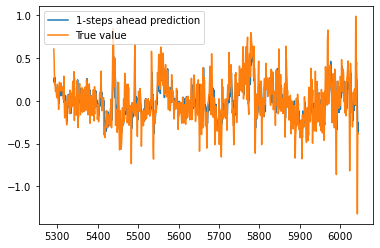

In [17]:
rf_rmse, y_test_rf = time_series_valid_test(X, y, 3, "test",  [1e-05, 500])

rf_rmse

**[Add your solution here]**

## (d) [2 marks]

It is often useful to check that your model is not worse than a very simple method of prediction. Compute the RMSE of a model that simply predicts the 1-step ahead value of `log_volume` $c_{t+1}$ as the current value $c_t$, and compare this to the best fitting random forest model.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.ndimage.interpolation import shift



# X_simple = data['log_volume'].to_numpy()
# y_simple = data['log_volume'].to_numpy()

y_temp = data['log_volume']
y_pred = data['log_volume']

np.sqrt(mean_squared_error(y_pred[:len(y_pred)-1], y_temp[1:]))



0.18890174010847652

The best fitting random forest model does better than the simple method of prediction as it has a lower rmse. 

**[Add your solution here]**

## (e) [2 marks]

Compute the feature importances of the best fitting model. Which feature is the most important and what is its feature importance value?

In [21]:

model_rf = RandomForestRegressor(random_state=42, 
                       ccp_alpha=1e-05, n_estimators=500, n_jobs=-1)
model_rf.fit(X,y.ravel())
model_rf.feature_importances_

array([0.05909577, 0.06289336, 0.04348415, 0.0371032 , 0.52852018,
       0.01550909, 0.01223347, 0.01108555, 0.01269354, 0.0138164 ,
       0.03372512, 0.02977974, 0.03705288, 0.03899174, 0.06401581])

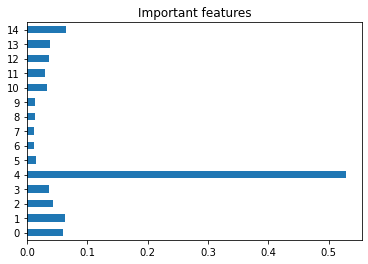

0.5285201844665299

In [23]:
import matplotlib.pyplot as plt
import pandas as pd


feat_importances = pd.Series(model_rf.feature_importances_)
feat_importances.plot(kind='barh')
plt.title("Important features")
plt.show()
max(feat_importances)


The most important feature is the log_volume at t-4.  

**[Add your solution here]**

# 2. SVM classification and regression [11 marks]

## (a) [2 marks]

In this question, a SVM is used for classification for the MNIST dataset. The following code loads the MNIST dataset, creates the test set, and to reduce training time, takes a random sample of 2000 points from the full training set to use as your actual training set stored in `X` and `y`. Do not shuffle the data and do not use a standard scaler.

Hint: Reading the solution to Question 9 in the Chapter 5 [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb) on the textbook website may help with this question.

In [2]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False, cache=True)
mnist.target = mnist.target.astype(np.int8)
X_train = mnist["data"][:60000]
X_test  = mnist["data"][60000:]
y_train = mnist["target"][:60000]
y_test  = mnist["target"][60000:]

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

N = 2000
split_obj = StratifiedShuffleSplit(n_splits=1,
                               test_size=N/60000, random_state=42)
for other_idx, subsample_idx in split_obj.split(X_train, y_train):
    X = X_train[subsample_idx]
    y = y_train[subsample_idx]

X.shape

(2000, 784)

**Task:** Consider fitting the linear SVM classifier (`LinearSVC`) with `max_iter=50000`. For this model, optimize the hyperparameter $C$ using 3-fold CV over the values $10^{-k}$, $k=0,1,\dots,9$, where the performance measure is accuracy. What is the best $C$ and what is the accuracy in this case?

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
import numpy as np
 
params = {"C": [10**0, 10**-1, 10**-2,10**-3, 10**-4, 10**-5, 10**-6, 10**-7, 10**-8, 10**-9]}
rd_search = RandomizedSearchCV(LinearSVC(max_iter=50000), params,random_state=42, cv=3,scoring="accuracy", n_jobs=-1)
rd_search.fit(X,y)

print("best value of hyperparameters is: ", rd_search.best_estimator_)
from sklearn.metrics import accuracy_score

y_pred = rd_search.best_estimator_.predict(X)
print("accuracy is: ", rd_search.best_score_)

best value of hyperparameters is:  LinearSVC(C=1e-07, max_iter=50000)
accuracy is:  0.8624974299636969


**[Add your solution here]**

## (b) [2 marks]

**Task:** Now consider fitting a SVM with a Gaussian RBF kernel and `max_iter=50000`. For this model, optimize the hyperparameters $C$ over the distrbution `uniform(1,10)` and $\gamma$ over the distribution `reciprocal(0.001, 0.1)` with 10 random samples. Again, use 3-fold CV and the performance measure is accuracy. What are the best hyperparameters and what is the accuracy in this case?

In [ ]:
from scipy.stats import reciprocal, uniform
from sklearn.svm import SVC

params = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
svm_rd_search_cv = RandomizedSearchCV(SVC(kernel='rbf', max_iter=50000), params, random_state=42, cv=3,scoring="accuracy")
svm_rd_search_cv.fit(X, y)
print("best value of hyperparameters is: ", svm_rd_search_cv.best_estimator_)
from sklearn.metrics import accuracy_score

y_pred = svm_rd_search_cv.best_estimator_.predict(X)
print("accuracy is: ", svm_rd_search_cv.best_score_)

best value of hyperparameters is:  SVC(C=4.745401188473625, gamma=0.07969454818643928, max_iter=50000)
accuracy is:  0.11250005627816723


**[Add your solution here]**

## (c) [2 mark]

**Task:** Choose the best model in (a) and (b). Then for this model, evaluate the accuracy on the test set, which is stored in `X_test` and `y_test`.

Best model is Linear SVC due to better accuracy score.

In [ ]:
y_pred_test = rd_search.best_estimator_.predict(X_test)
print("accuracy is: ", accuracy_score(y_test, y_pred_test))

accuracy is:  0.8873


**[Add your solution here]**

## (d) [3 marks]

Consider the California housing data from Homework 1 using the same training and test set there. The data is obtained using the code below, which comes from Homework 1, and the training set is stored in `X` and `y`. Do not shuffle the data.

Hint: Reading the solution to Question 10 in the Chapter 5 [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb) on the textbook website may help with this question.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


import os
import tarfile
from six.moves import urllib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_url, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

HOUSING_URL = ("https://raw.githubusercontent.com/ageron/"+
               "handson-ml2/master/datasets/housing/housing.tgz")
fetch_housing_data(HOUSING_URL)
data = load_housing_data()

data["income_cat"] = np.ceil(data["median_income"] / 1.5)
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
X_raw = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
num_features = X_raw.drop("ocean_proximity", axis=1)
num_attribs = list(num_features)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X = full_pipeline.fit_transform(X_raw)
X_test_raw = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test = full_pipeline.transform(X_test_raw)

**Task:** Consider SVM regression with a Gaussian RBF kernel and a sigmoid kernel with `max_iter=50000`. For both models, use randomized search to choose good hyperparameter values for `C` and `gamma`, and set the arguement `random_state=42`. For both models, optimize the hyperparameters $C$ over the distrbution `uniform(1,10)` and $\gamma$ over the distribution `reciprocal(0.001, 0.1)` with 10 random samples. Again, use 3-fold CV and the performance measure is MSE. What are the best hyperparameters and what is the MSE in this case?

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

params = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rbf_svr_rd_search_cv = RandomizedSearchCV(SVR(kernel='rbf', max_iter=50000), params,  cv=3, 
                                           scoring="neg_mean_squared_error", random_state=42, n_jobs=-1)
rbf_svr_rd_search_cv.fit(X, y)

RandomizedSearchCV(cv=3, estimator=SVR(max_iter=50000), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0cc6bb1a90>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0cc6bb1fd0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
print("Best hyperparameters are:", rbf_svr_rd_search_cv.best_estimator_)

Best hyperparameters are: SVR(C=4.745401188473625, gamma=0.07969454818643928, max_iter=50000)


In [ ]:
import numpy as np

print("MSE is:",-rbf_svr_rd_search_cv.best_score_)

MSE is: 13877012057.239176


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

params = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
sig_svr_rd_search_cv = RandomizedSearchCV(SVR(kernel='sigmoid'), params, n_iter=10, cv=3, 
                                           scoring="neg_mean_squared_error",return_train_score=True,random_state=42, n_jobs=-1)
sig_svr_rd_search_cv.fit(X, y)

RandomizedSearchCV(cv=3, estimator=SVR(kernel='sigmoid'), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0cc7d27250>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0cc7d27090>},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error')

In [ ]:
print("Best hyperparameters are:",sig_svr_rd_search_cv.best_estimator_)

Best hyperparameters are: SVR(C=4.745401188473625, gamma=0.07969454818643928, kernel='sigmoid')


In [ ]:
import numpy as np

print("MSE is:", -sig_svr_rd_search_cv.best_score_)

MSE is: 13744315287.792427


**[Add your solution here]**

## (e) [2 marks]

**Task:** Choose the best model in (d). Then for this model, evaluate the RMSE on the test set, which is stored in `X_test` and `y_test`.

SVM regression with sigmoid kernel has lower mse and is therefore our best model.  

In [ ]:
from sklearn.metrics import mean_squared_error

y_svr_pred_test = sig_svr_rd_search_cv.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_svr_pred_test)

np.sqrt(mse)

114741.28850451492

**[Add your solution here]**

# 3. Voting Classifiers [8 marks]
## (a)  [4 marks]

Consider the MNIST dataset. To save computational time, split it into a smaller training set (the first 5000 observations) and a validation set (the next 1000 observations) as given by the following code.

In [4]:
N = 5000
M = 6000
X_train = mnist["data"][:N]
X_val  = mnist["data"][N:M]
y_train = mnist["target"][:N]
y_val = mnist["target"][N:M]

Do not shuffle the data and do not use a standard scaler. Train the following classifiers on the training set:

(i) a random forest classifier with arguments `n_estimators=100, n_jobs=-1, random_state=42`,

(ii) an extra-trees classifier with arguments `n_estimators=100, n_jobs=-1, random_state=42`,

(iii) an AdaBoost classifier `n_estimators=50, learning_rate=0.2, random_state=42`,

(iv) a gradient boosting classifier using the class `GradientBoostingClassifier()` with arguments `max_depth=2, n_estimators=10, learning_rate=0.25, random_state=42`.

Report the accuracy of each trained classifier on the validation set.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

rndforest_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rndforest_clf.fit(X_train, y_train)

y_pred_rndforest_clf_val = rndforest_clf.predict(X_val)
print("accuracy of RandomForestClassifier is: ", accuracy_score(y_val, y_pred_rndforest_clf_val))

accuracy of RandomForestClassifier is:  0.939


In [6]:
extrees_clf = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)
extrees_clf.fit(X_train, y_train)

y_pred_extrees_clf_val = extrees_clf.predict(X_val)
print("accuracy of ExtraTreesClassifier is: ", accuracy_score(y_val, y_pred_extrees_clf_val))

accuracy of ExtraTreesClassifier is:  0.947


In [7]:
from sklearn.tree import DecisionTreeClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=50,
    algorithm="SAMME.R", learning_rate=0.2, random_state=42)
ada_clf.fit(X_train, y_train)

y_pred_adaclf_val = ada_clf.predict(X_val)
print("accuracy of AdaBoostClassifier is: ", accuracy_score(y_val, y_pred_adaclf_val))

accuracy of AdaBoostClassifier is:  0.736


In [8]:
gb_clf = GradientBoostingClassifier(max_depth=2, n_estimators=10, learning_rate=0.25, random_state=42)
gb_clf.fit(X_train, y_train)

y_pred_gb_clf_val = gb_clf.predict(X_val)
print("accuracy of GradientBoostingClassifier is: ", accuracy_score(y_val, y_pred_gb_clf_val))

accuracy of GradientBoostingClassifier is:  0.834


**[Add your solution here]**

## (b)  [4 marks]
Train a hard-voting and a soft-voting ensemble classifier based on the models in (a). Evaluate each voting classifier on the validation set. Comment on whether the performance of the ensemble model is better or worse than the individual models in (a) and why that is the case.

**[Add your solution here]**

In [9]:
from sklearn.ensemble import VotingClassifier

classifers = [
    ("rndforest_clf", rndforest_clf),
    ("extrees_clf", extrees_clf),
    ("ada_clf", ada_clf),
    ("gb_clf", gb_clf),
]
hard_voting_clf = VotingClassifier(estimators=classifers, voting='hard')
hard_voting_clf.fit(X_train, y_train)

y_pred_hard_voting_clf_val = hard_voting_clf.predict(X_val)
print("accuracy of hard_voting_clf is: ", accuracy_score(y_val, y_pred_hard_voting_clf_val))

accuracy of hard_voting_clf is:  0.923


In [10]:
soft_voting_clf = VotingClassifier(estimators=classifers, voting='soft')
soft_voting_clf.fit(X_train, y_train)

y_pred_soft_voting_clf_val = soft_voting_clf.predict(X_val)
print("accuracy of soft_voting_clf is: ", accuracy_score(y_val, y_pred_soft_voting_clf_val))

accuracy of soft_voting_clf is:  0.926


2 of individual classifiers perform poorly wheres two are better than ensemble.

Performance of hard-voting ensemble classifier is better than all individual classifiers except ExtraTreesClassifier and RandomForestClassifier. Hard-voting classifier takes majority voting across classifiers. It is possible that the one of the top performing classifiers namely ExtraTreesClassifier or RandomForestClassifer is wrong for same cases as other classifiers adversely affecting the majority vote.

Performance of soft-voting ensemble classifier is better than all individual classifiers except ExtraTreesClassifier and RandomForestClassifier. Soft-voting classifier uses highest probability averaged over all individual classifiers. It is possible that the low performing classifier lower the average probability greatly leading to lower accuracy on the ensemble.

Performance of soft-voting classifier is slightly better than that of hard-voting classifier. Averaging probabilites in soft-voting classifiers is beneficial but not too much as the lower performing individual classifiers are affecting accuracy.

# 4. Stacking [9 marks]

We continue with the setting of Question 3. The training set, validation set and test set are the same. In Question 3, we have used predetermined rules (that is, hard-voting and soft-voting) to build the ensemble prediction. **Stacking** is an ensemble method in which you train a model (called a **blender**) to aggregate the result of each predictor into an ensemble prediction.

Hint: Reading the subsection "Stacking" in Chapter 7 of the textbook and the solution to Question 9 in the Chapter 7 [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb) on the textbook website may help with this question.

## (a)  [3 marks]

For each of the four classifiers in Question 3(a), make 5000 clean predictions on the training set with 3-fold cross validation using `sklearn.model_selection.cross_val_predict()`. You should end up with four predictions per observation. Print at least the first 5 rows of `pred`. Next, apply one-hot encoding to `pred` since these predictions are class labels.

In [11]:
from sklearn.model_selection import cross_val_predict
estimators = [rndforest_clf, extrees_clf, ada_clf,  gb_clf]

X_val_predictions = np.empty((len(X_train), len(estimators)))

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = cross_val_predict(estimator, X_train, y_train, cv=3)

X_val_predictions[:5,]

array([[5., 5., 3., 3.],
       [0., 0., 5., 0.],
       [4., 4., 4., 4.],
       [1., 1., 1., 1.],
       [9., 9., 9., 9.]])

In [12]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
X_val_predictions_hot = cat_encoder.fit_transform(X_val_predictions)
X_val_predictions_hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

**[Add your solution here]**

## (b) [3 marks]
Use the predictions in (a) as features and the actual label of the observations as the target. Train a random forest classifier on the training set with the parameters `n_estimators=100, random_state=42`.  This classifier is a blender. 

In [13]:
rnd_forest_blender = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions_hot, y_train)

RandomForestClassifier(oob_score=True, random_state=42)

**[Add your solution here]**

## (c) [3 marks]

Obtain the predictions of the blender on the validation set by feeding predictions on the validation set from the four classifiers in Question 3(a) into the blender trained in Question 4(b). Do not retrain the blender. These are called stacking predictions. Report the accuracy of your stacking predictions on the validation set and compare this to the results in Question 3(b).

In [14]:
X_val_predictions_val = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions_val[:, index] = estimator.predict(X_val)

In [15]:
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
X_val_predictions_val_hot = cat_encoder.fit_transform(X_val_predictions_val)

y_pred = rnd_forest_blender.predict(X_val_predictions_val_hot)
accuracy_score(y_val, y_pred)



0.947

This is better than the voting classifer and equal to the best individual classifer (ExtraTreesClassifier)

**[Add your solution here]**